In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets import generate_pinwheel, generate_spiral, generate_checkerboard, generate_gaussian_mixtures

In [2]:
rng = np.random.default_rng(seed=54301)

X_pinwheel = generate_pinwheel(num=2000, rng=rng)
pinwheel_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_pinwheel)),
    batch_size=128,
    shuffle=True
)

X_spiral = generate_spiral(num=2000, rng=rng)
spiral_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_spiral)),
    batch_size=128,
    shuffle=True
)


X_checkerboard = generate_checkerboard(num=2000, rng=rng)
checkerboard_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_checkerboard)),
    batch_size=128,
    shuffle=True
)


X_gmm = generate_gaussian_mixtures(num=2000, rng=rng)
gmm_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_gmm)),
    batch_size=128,
    shuffle=True
)

In [3]:
from vae import train_vae
from gan import train_gan


Training VAE...


Epochs: 100%|█████████████████████████████████| 800/800 [00:50<00:00, 15.72it/s]


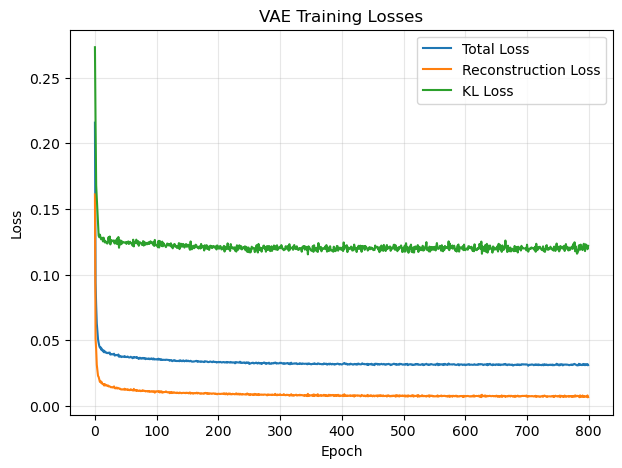

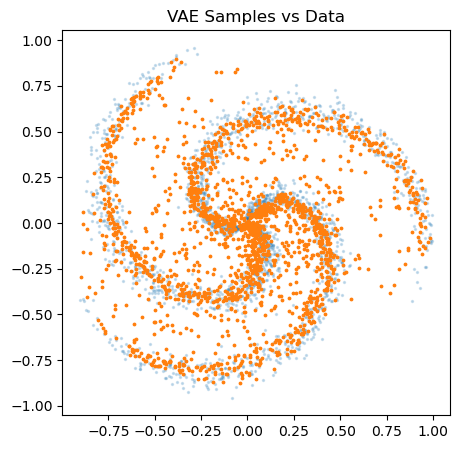

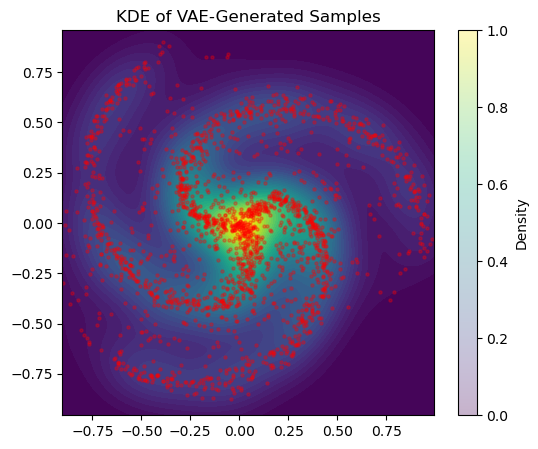


KDE Estimated Log-Likelihood (VAE): -0.6800



In [4]:
train_vae(pinwheel_loader, X_pinwheel, epochs=800, device = "cpu")


Training GAN...


Epochs: 100%|█████████████████████████████████| 800/800 [00:32<00:00, 24.54it/s]


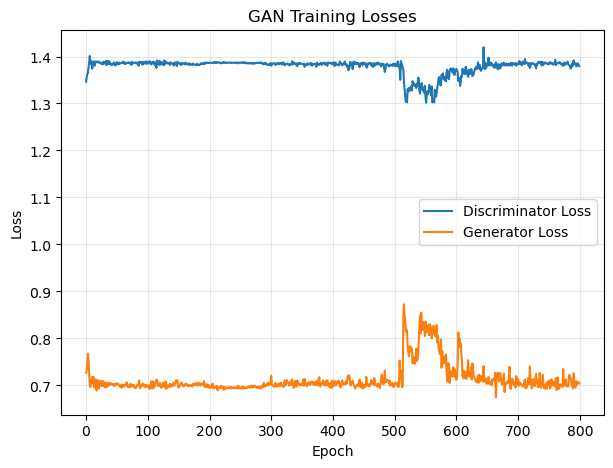

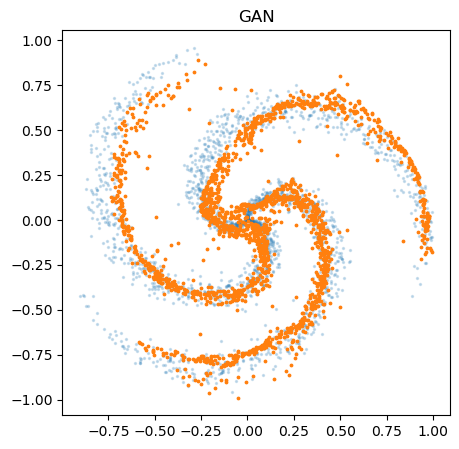

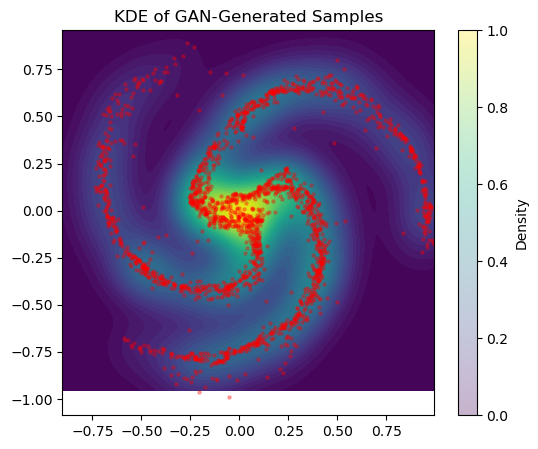


KDE Estimated Log-Likelihood (GAN): -0.7184



In [5]:
train_gan(pinwheel_loader, X_pinwheel, epochs=800, device="cpu")


Training VAE...


Epochs: 100%|███████████████████████████████| 1500/1500 [01:42<00:00, 14.66it/s]


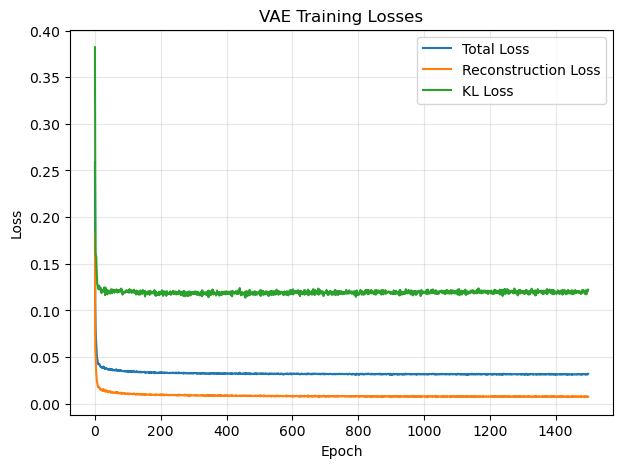

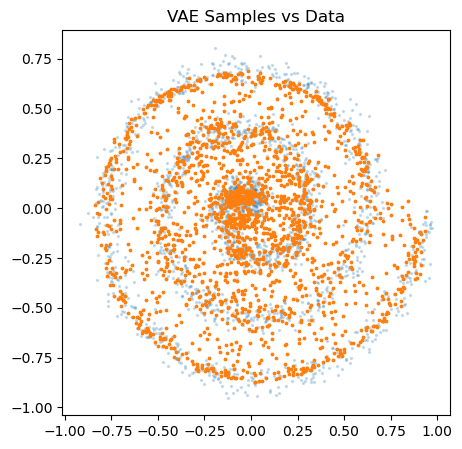

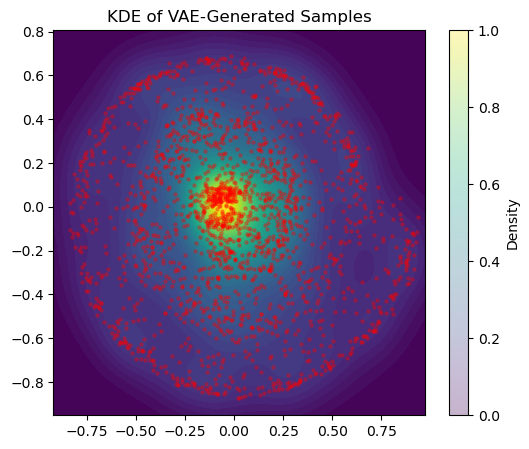


KDE Estimated Log-Likelihood (VAE): -0.7564



In [6]:
train_vae(spiral_loader, X_spiral, epochs=1500, device="cpu")


Training GAN...


Epochs: 100%|███████████████████████████████| 1200/1200 [00:46<00:00, 25.74it/s]


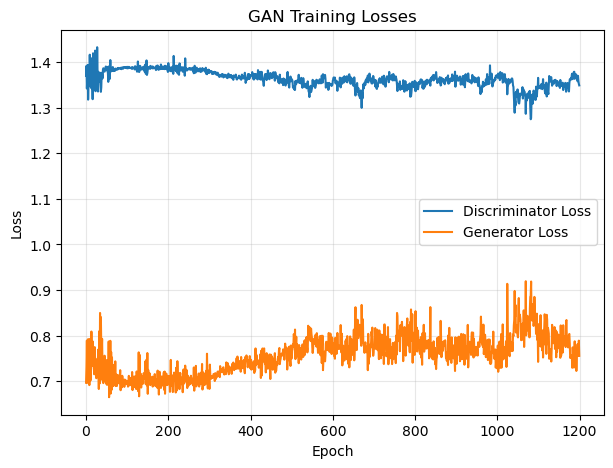

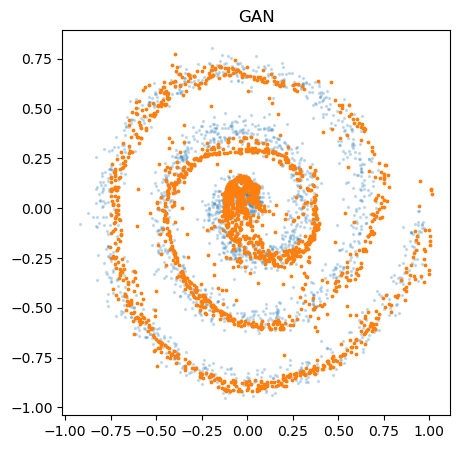

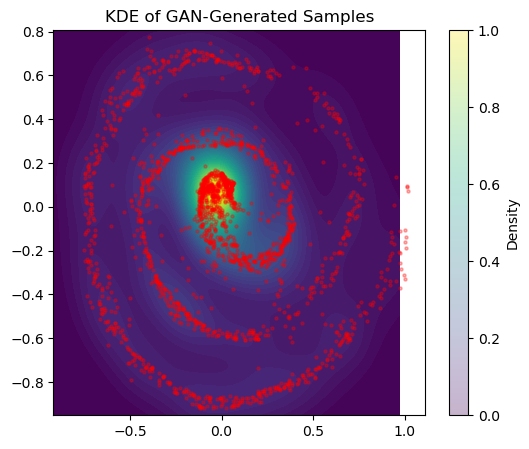


KDE Estimated Log-Likelihood (GAN): -0.7845



In [7]:
train_gan(spiral_loader, X_spiral, epochs=1200, device="cpu")


Training VAE...


Epochs: 100%|███████████████████████████████| 1000/1000 [01:05<00:00, 15.31it/s]


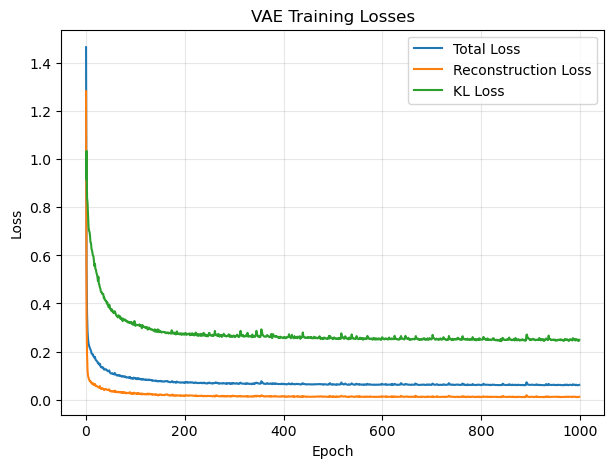

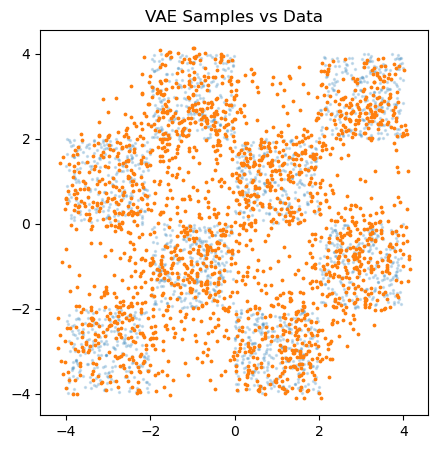

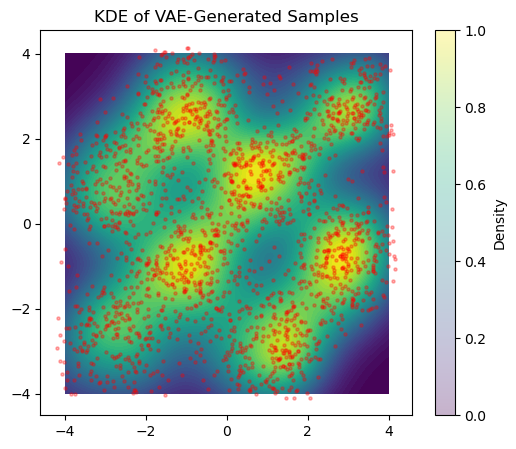


KDE Estimated Log-Likelihood (VAE): -4.0842



In [8]:
train_vae(checkerboard_loader, X_checkerboard, epochs=1000, device="cpu")


Training GAN...


Epochs: 100%|█████████████████████████████████| 650/650 [00:28<00:00, 22.49it/s]


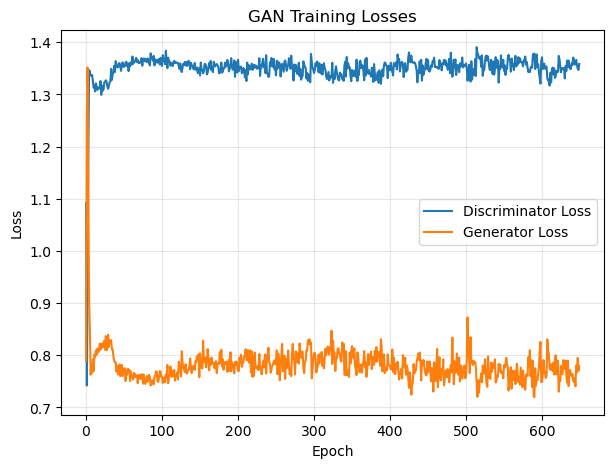

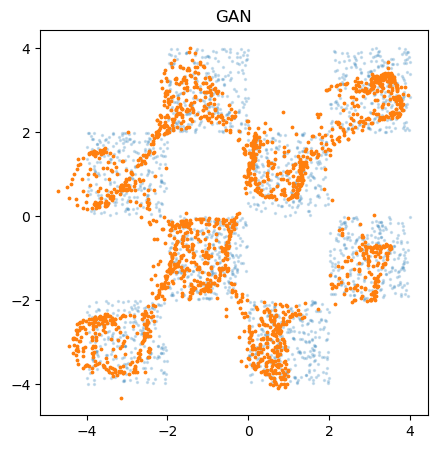

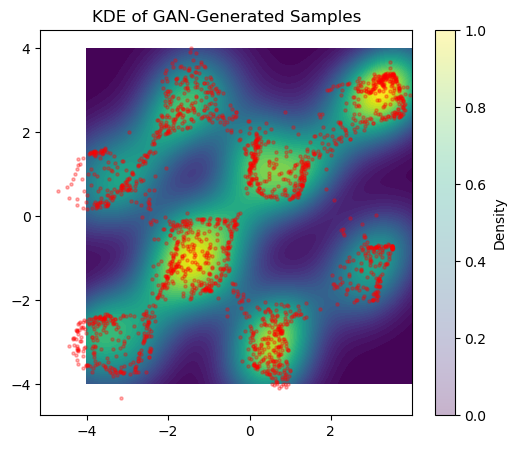


KDE Estimated Log-Likelihood (GAN): -4.0143



In [9]:
train_gan(checkerboard_loader, X_checkerboard, epochs=650, device="cpu")


Training VAE...


Epochs: 100%|█████████████████████████████████| 800/800 [01:05<00:00, 12.15it/s]


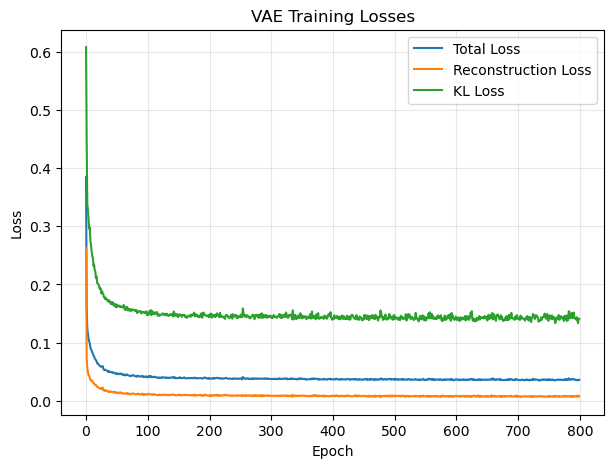

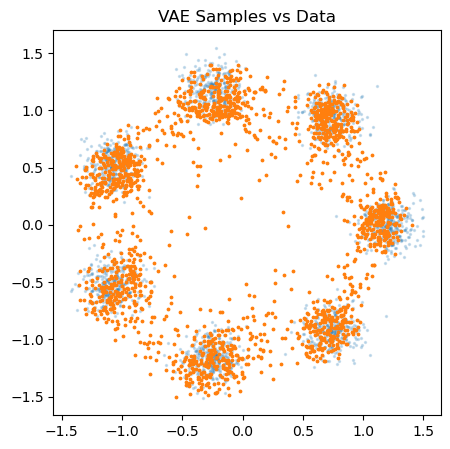

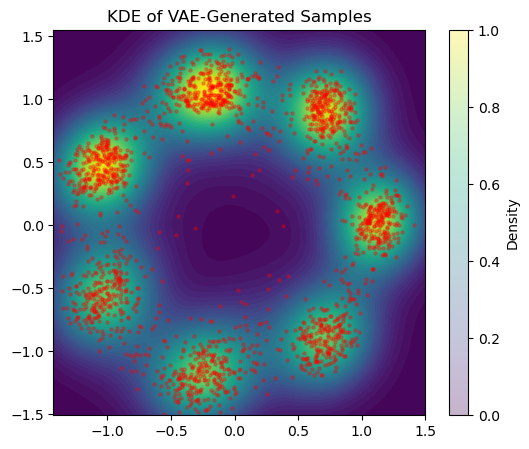


KDE Estimated Log-Likelihood (VAE): -1.4695



In [10]:
train_vae(gmm_loader, X_gmm, epochs=800, device="cpu")


Training GAN...


Epochs: 100%|█████████████████████████████████| 400/400 [00:16<00:00, 24.92it/s]


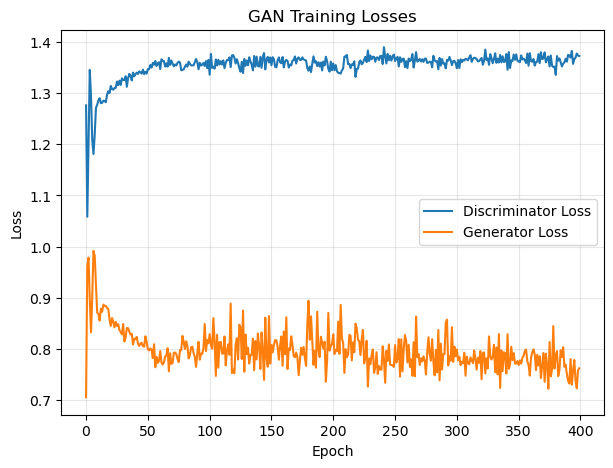

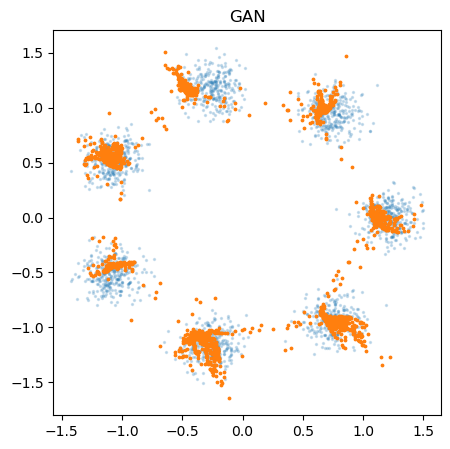

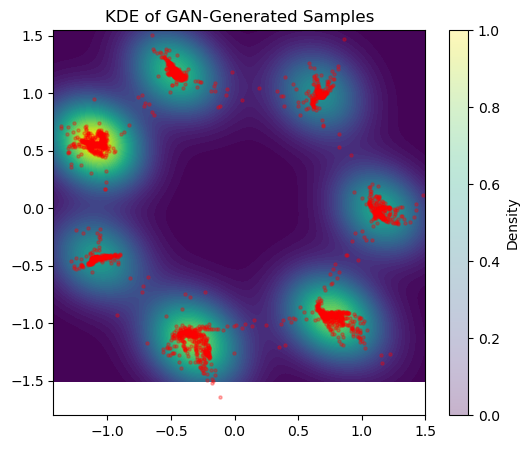


KDE Estimated Log-Likelihood (GAN): -1.3809



In [11]:
train_gan(gmm_loader, X_gmm, epochs=400, device="cpu")

To quantitatively compare sample quality between models, we use a 2-D Kernel Density Estimator (KDE).
We draw samples from each model and fit a scipy.stats.gaussian_kde to these samples.
Then we evaluate the log-likelihood of a held-out real dataset under this KDE using logpdf.
The resulting average log-likelihood is an apples-to-apples metric that works even for models without tractable likelihoods (GANs, VAEs, etc.).
Higher KDE log-likelihood indicates that the model’s samples better match the true data distribution.